# Using JAXNS to globally optimise Neural Networks

Neural network training is typically done with maximum likelihood estimation. Given the number of parameter invariances in neural network architectures, this often introduces a large number of local minima, making global optimisation very difficult.

JAXNS can easily navigate complex degeneracies during it's calculation of the Bayesian evidence. This yields a powerful tool for globally optimising neural networks.

## What we'll do in this notebook
1. Define a neural network model
2. Find its maximum likelihood parameters using JAXNS


## Data

We'll use the N-bit majority problem as our data. This is a binary classification problem where the input is a sequence of bits and the output is 1 if the majority of the bits are 1, and 0 otherwise. It is known that the $n$ bit problem requires at least $n$ hidden units to solve. We will show that the global optimum is found by JAXNS with $n$ hidden units, and not with $n-1$.

In [1]:
import os

os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={os.cpu_count()}"

try:
    import haiku as hk
except ImportError:
    print("You must `pip install dm-haiku` first.")
    raise

import jax
import tensorflow_probability.substrates.jax as tfp
from jax import random, numpy as jnp
import numpy as np

import itertools

np.random.seed(42)

tfpd = tfp.distributions


In [2]:


# Generate data


def generate_parity_dataset(N):
    """
    Generates a dataset for the N-bit parity problem.

    Args:
        N (int): Number of bits in each sample.

    Returns:
        X (np.ndarray): Input features of shape (num_samples, N).
        y (np.ndarray): Labels of shape (num_samples,).
    """
    # Generate random binary inputs
    X = np.asarray(list(itertools.product([0, 1], repeat=N)))
    # Compute parity (even or odd number of ones)
    y = np.mod(np.sum(X, axis=1), 2)
    return X.astype(np.float32), y.astype(np.float32)


num_variables = 5
x, y = generate_parity_dataset(num_variables)
print("Data:")

for input, output in zip(x, y):
    print(f"{input} -> {output}")


Data:
[0. 0. 0. 0. 0.] -> 0.0
[0. 0. 0. 0. 1.] -> 1.0
[0. 0. 0. 1. 0.] -> 1.0
[0. 0. 0. 1. 1.] -> 0.0
[0. 0. 1. 0. 0.] -> 1.0
[0. 0. 1. 0. 1.] -> 0.0
[0. 0. 1. 1. 0.] -> 0.0
[0. 0. 1. 1. 1.] -> 1.0
[0. 1. 0. 0. 0.] -> 1.0
[0. 1. 0. 0. 1.] -> 0.0
[0. 1. 0. 1. 0.] -> 0.0
[0. 1. 0. 1. 1.] -> 1.0
[0. 1. 1. 0. 0.] -> 0.0
[0. 1. 1. 0. 1.] -> 1.0
[0. 1. 1. 1. 0.] -> 1.0
[0. 1. 1. 1. 1.] -> 0.0
[1. 0. 0. 0. 0.] -> 1.0
[1. 0. 0. 0. 1.] -> 0.0
[1. 0. 0. 1. 0.] -> 0.0
[1. 0. 0. 1. 1.] -> 1.0
[1. 0. 1. 0. 0.] -> 0.0
[1. 0. 1. 0. 1.] -> 1.0
[1. 0. 1. 1. 0.] -> 1.0
[1. 0. 1. 1. 1.] -> 0.0
[1. 1. 0. 0. 0.] -> 0.0
[1. 1. 0. 0. 1.] -> 1.0
[1. 1. 0. 1. 0.] -> 1.0
[1. 1. 0. 1. 1.] -> 0.0
[1. 1. 1. 0. 0.] -> 1.0
[1. 1. 1. 0. 1.] -> 0.0
[1. 1. 1. 1. 0.] -> 0.0
[1. 1. 1. 1. 1.] -> 1.0


In [3]:
from jaxns.internals.maps import pytree_unravel
from jaxns import Prior, Model
import jaxns.framework.context as ctx
from jaxns import NestedSampler, TerminationCondition
    
def run(n_hidden_units):
    def prior_model():
        def compute_logits(x):
            mlp = hk.Sequential([
                hk.Linear(n_hidden_units),
                jax.nn.relu,
                hk.Linear(1)
            ])
            return mlp(x)
    
        init, apply = hk.transform(compute_logits)
        init_params = init(random.PRNGKey(0), x)
        # Convert haiku to jaxns params
        ctx_params = ctx.convert_external_params(init_params, prefix='haiku_model')
        # Flatten, model, then unflatten to use
        ravel_fn, unravel_fn = pytree_unravel(ctx_params)
        ndims = ravel_fn(init_params).size
        flat_params = yield Prior(tfpd.Uniform(-10. * jnp.ones(ndims), 10. * jnp.ones(ndims)), name='flat_params')
        params = unravel_fn(flat_params)
        logits = apply(params, jax.random.PRNGKey(0), x)[:, 0]  # [n]
        return logits.astype(jnp.float32)
    
    
    def log_likelihood(logits):
        # Classification probelm, so we use a Bernoulli likelihood
        return tfpd.Bernoulli(logits=logits).log_prob(y).mean()
    
    
    model = Model(prior_model=prior_model, log_likelihood=log_likelihood)
    
    model.sanity_check(random.PRNGKey(0), S=100)
    
    ns = NestedSampler(model=model)
    
    term_reason, state = jax.jit(ns)(
        random.PRNGKey(42),
        TerminationCondition(atol=0.01)
    )
    results = ns.to_results(term_reason, state)
    ns.summary(results)
    ns.plot_diagnostics(results)
    ns.plot_cornerplot(results)
    
    solution = results.U_samples[jnp.argmax(results.log_L_samples)]
    
    logits = model.prepare_input(solution)[0]
    predictions = jax.nn.sigmoid(logits)
    for i in range(len(y)):
        pred = predictions[i]
        print(f"{i}: {x[i]} -> {y[i]} | pred: {pred} {'✓' if (pred > 0.5) == y[i] else '✗'}")
    
    accuracy = jnp.mean((predictions > 0.5) == y)
    print(f"Accuracy: {accuracy * 100:.1f}%")



/home/albert/miniconda3/envs/jaxns_py/lib/python3.11/site-packages/jaxns/internals/mixed_precision.py:14: UserWarning: JAX x64 is not enabled. Setting it now. Check for errors.
  warnings.warn("JAX x64 is not enabled. Setting it now. Check for errors.")
INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': 
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


INFO:jaxns:Sanity check...
INFO:jaxns:Sanity check passed


Running over 12 devices.
--------
Termination Conditions:
absolute spread of live points < atol
--------
likelihood evals: 11301639
samples: 46980
phantom samples: 0
likelihood evals / sample: 240.6
phantom fraction (%): 0.0%
--------
logZ=-7.606 +- 0.078
max(logL)=-0.001
H=-4.46
ESS=2219
--------
flat_params[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
flat_params[0]: -3.2 +- 5.1 | -9.0 / -4.2 / 4.7 | 7.7 | 7.7
flat_params[1]: -3.1 +- 5.1 | -9.1 / -4.0 / 5.0 | -0.6 | -0.6
flat_params[2]: -3.1 +- 5.2 | -8.9 / -4.3 / 4.9 | -6.0 | -6.0
flat_params[3]: -3.3 +- 5.0 | -8.9 / -4.5 / 4.3 | -7.4 | -7.4
flat_params[4]: -2.9 +- 5.2 | -8.9 / -3.9 / 5.0 | -8.9 | -8.9
flat_params[5]: -1.9 +- 5.4 | -8.5 / -2.6 / 6.3 | 9.3 | 9.3
flat_params[6]: -1.7 +- 5.3 | -8.4 / -2.3 / 6.2 | 8.1 | 8.1
flat_params[7]: -1.7 +- 5.4 | -8.4 / -2.3 / 6.4 | -4.1 | -4.1
flat_params[8]: -1.5 +- 5.3 | -8.5 / -2.0 / 6.1 | 4.7 | 4.7
flat_params[9]: -1.3 +- 5.3 | -8.2 / -1.7 / 6.7 | -4.6 | -4.6
flat

/home/albert/miniconda3/envs/jaxns_py/lib/python3.11/site-packages/jaxns/plotting.py:45: UserWarning: Found samples with zero likelihood evaluations.
  warnings.warn("Found samples with zero likelihood evaluations.")
/home/albert/miniconda3/envs/jaxns_py/lib/python3.11/site-packages/jaxns/plotting.py:49: RuntimeWarning: divide by zero encountered in divide
  1. / num_likelihood_evaluations_per_sample


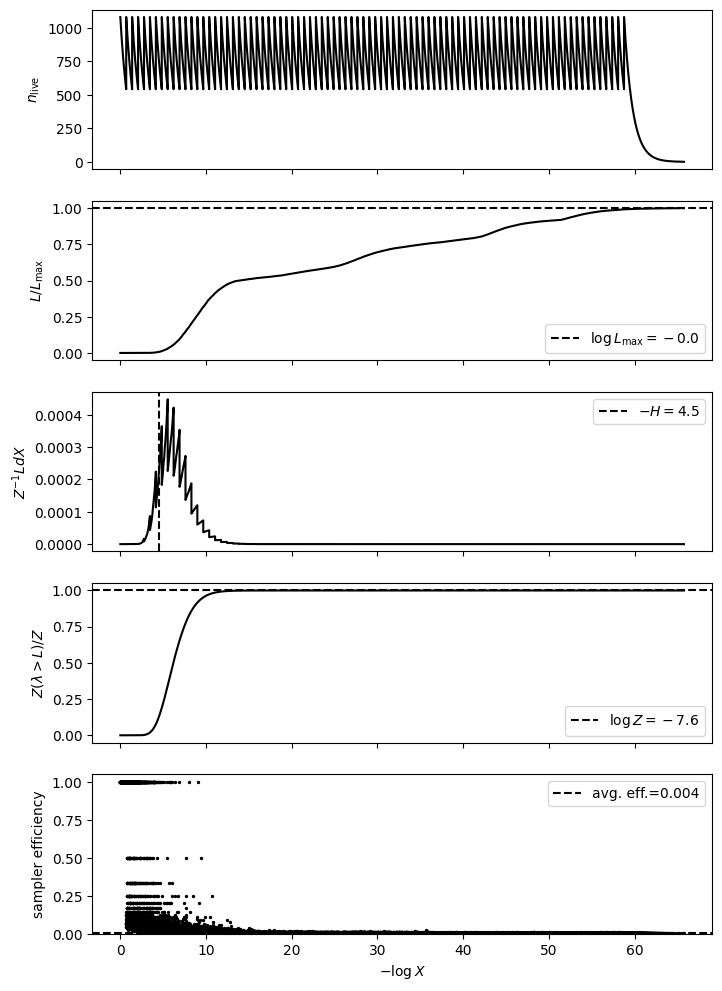

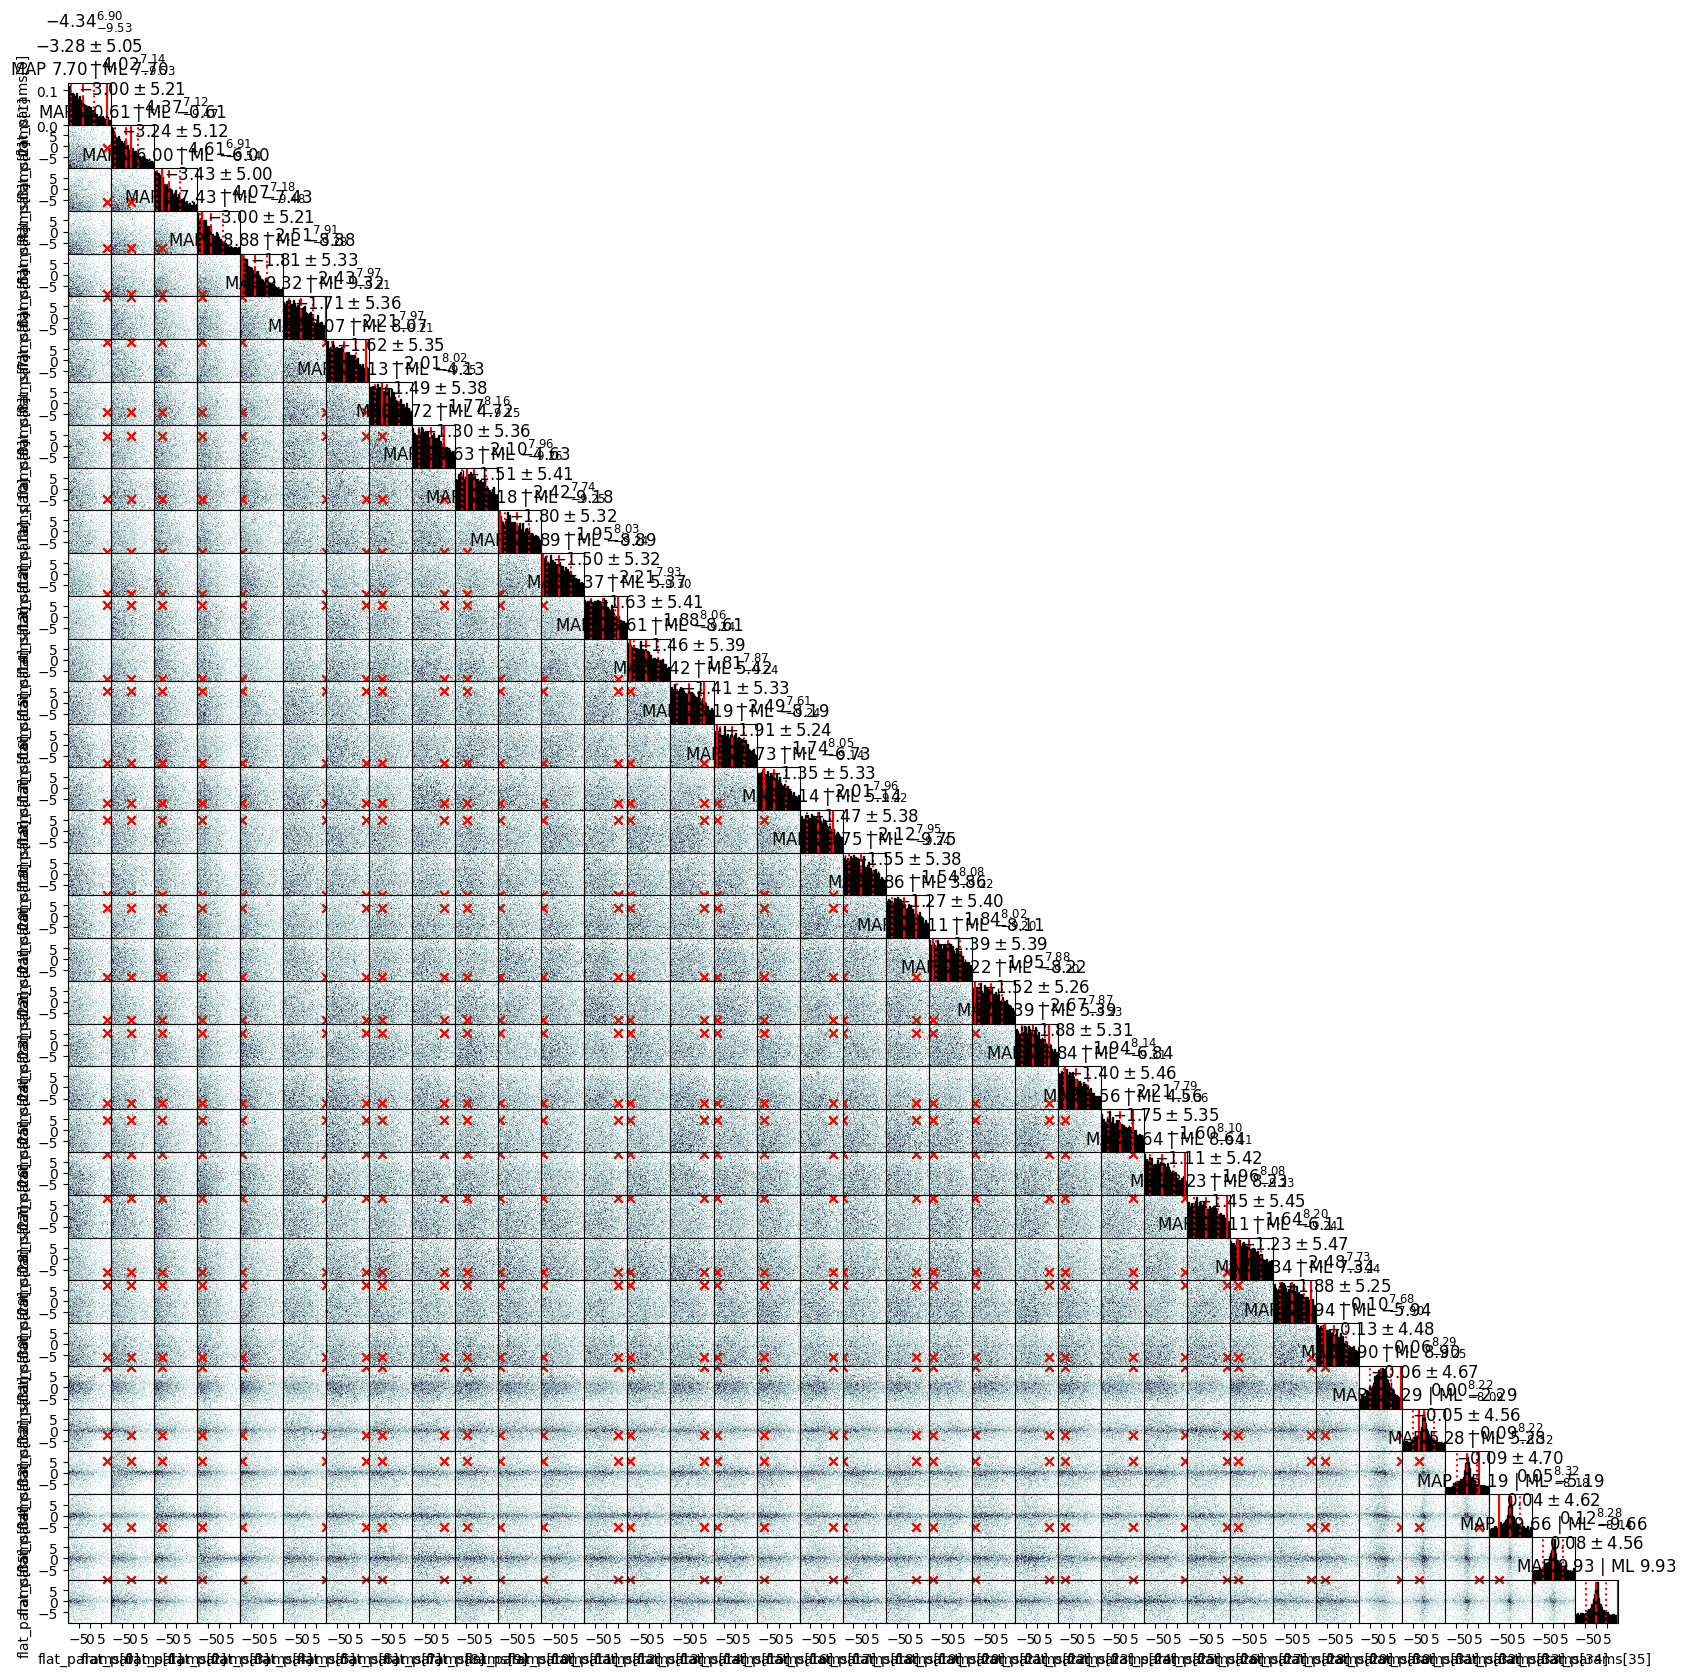

0: [0. 0. 0. 0. 0.] -> 0.0 | pred: 0.0001603582495590672 ✓
1: [0. 0. 0. 0. 1.] -> 1.0 | pred: 0.9999916553497314 ✓
2: [0. 0. 0. 1. 0.] -> 1.0 | pred: 0.9998642206192017 ✓
3: [0. 0. 0. 1. 1.] -> 0.0 | pred: 4.826125586987473e-05 ✓
4: [0. 0. 1. 0. 0.] -> 1.0 | pred: 0.9998642206192017 ✓
5: [0. 0. 1. 0. 1.] -> 0.0 | pred: 0.006293473765254021 ✓
6: [0. 0. 1. 1. 0.] -> 0.0 | pred: 4.47046147655783e-07 ✓
7: [0. 0. 1. 1. 1.] -> 1.0 | pred: 0.9998515844345093 ✓
8: [0. 1. 0. 0. 0.] -> 1.0 | pred: 0.9998642206192017 ✓
9: [0. 1. 0. 0. 1.] -> 0.0 | pred: 0.0005624053883366287 ✓
10: [0. 1. 0. 1. 0.] -> 0.0 | pred: 0.007503319066017866 ✓
11: [0. 1. 0. 1. 1.] -> 1.0 | pred: 0.9998642206192017 ✓
12: [0. 1. 1. 0. 0.] -> 0.0 | pred: 2.489727921783924e-05 ✓
13: [0. 1. 1. 0. 1.] -> 1.0 | pred: 0.9998642206192017 ✓
14: [0. 1. 1. 1. 0.] -> 1.0 | pred: 0.9988038539886475 ✓
15: [0. 1. 1. 1. 1.] -> 0.0 | pred: 2.1107047359691933e-05 ✓
16: [1. 0. 0. 0. 0.] -> 1.0 | pred: 0.9999055862426758 ✓
17: [1. 0. 0. 0. 1.

In [4]:
run(num_variables)


INFO:jaxns:Sanity check...
INFO:jaxns:Sanity check passed


Running over 12 devices.
--------
Termination Conditions:
absolute spread of live points < atol
--------
likelihood evals: 6574962
samples: 33300
phantom samples: 0
likelihood evals / sample: 197.4
phantom fraction (%): 0.0%
--------
logZ=-6.456 +- 0.078
max(logL)=-0.085
H=-3.66
ESS=1724
--------
flat_params[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
flat_params[0]: -3.2 +- 5.2 | -9.1 / -4.4 / 4.5 | 9.8 | 9.8
flat_params[1]: -3.4 +- 4.8 | -9.0 / -4.4 / 4.1 | -8.8 | -8.8
flat_params[2]: -3.3 +- 5.1 | -9.1 / -4.4 / 4.5 | 0.7 | 0.7
flat_params[3]: -3.1 +- 5.0 | -8.9 / -4.2 / 4.6 | 7.6 | 7.6
flat_params[4]: -1.6 +- 5.3 | -8.3 / -2.2 / 6.3 | -4.9 | -4.9
flat_params[5]: -1.9 +- 5.1 | -8.5 / -2.3 / 5.5 | -6.0 | -6.0
flat_params[6]: -1.4 +- 5.4 | -8.4 / -2.0 / 6.7 | -9.2 | -9.2
flat_params[7]: -1.9 +- 5.4 | -8.7 / -2.8 / 6.2 | -6.9 | -6.9
flat_params[8]: -1.7 +- 5.3 | -8.4 / -2.2 / 6.3 | -7.7 | -7.7
flat_params[9]: -1.7 +- 5.1 | -8.2 / -2.0 / 5.6 | -8.0 | -8.0
fla

/home/albert/miniconda3/envs/jaxns_py/lib/python3.11/site-packages/jaxns/plotting.py:45: UserWarning: Found samples with zero likelihood evaluations.
  warnings.warn("Found samples with zero likelihood evaluations.")
/home/albert/miniconda3/envs/jaxns_py/lib/python3.11/site-packages/jaxns/plotting.py:49: RuntimeWarning: divide by zero encountered in divide
  1. / num_likelihood_evaluations_per_sample


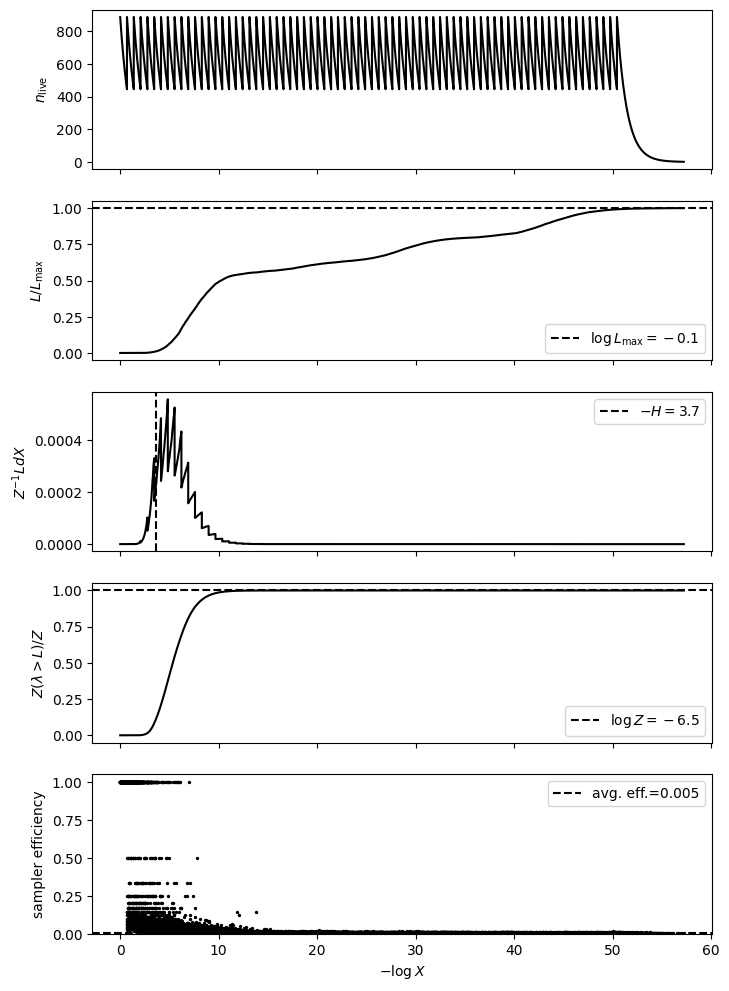

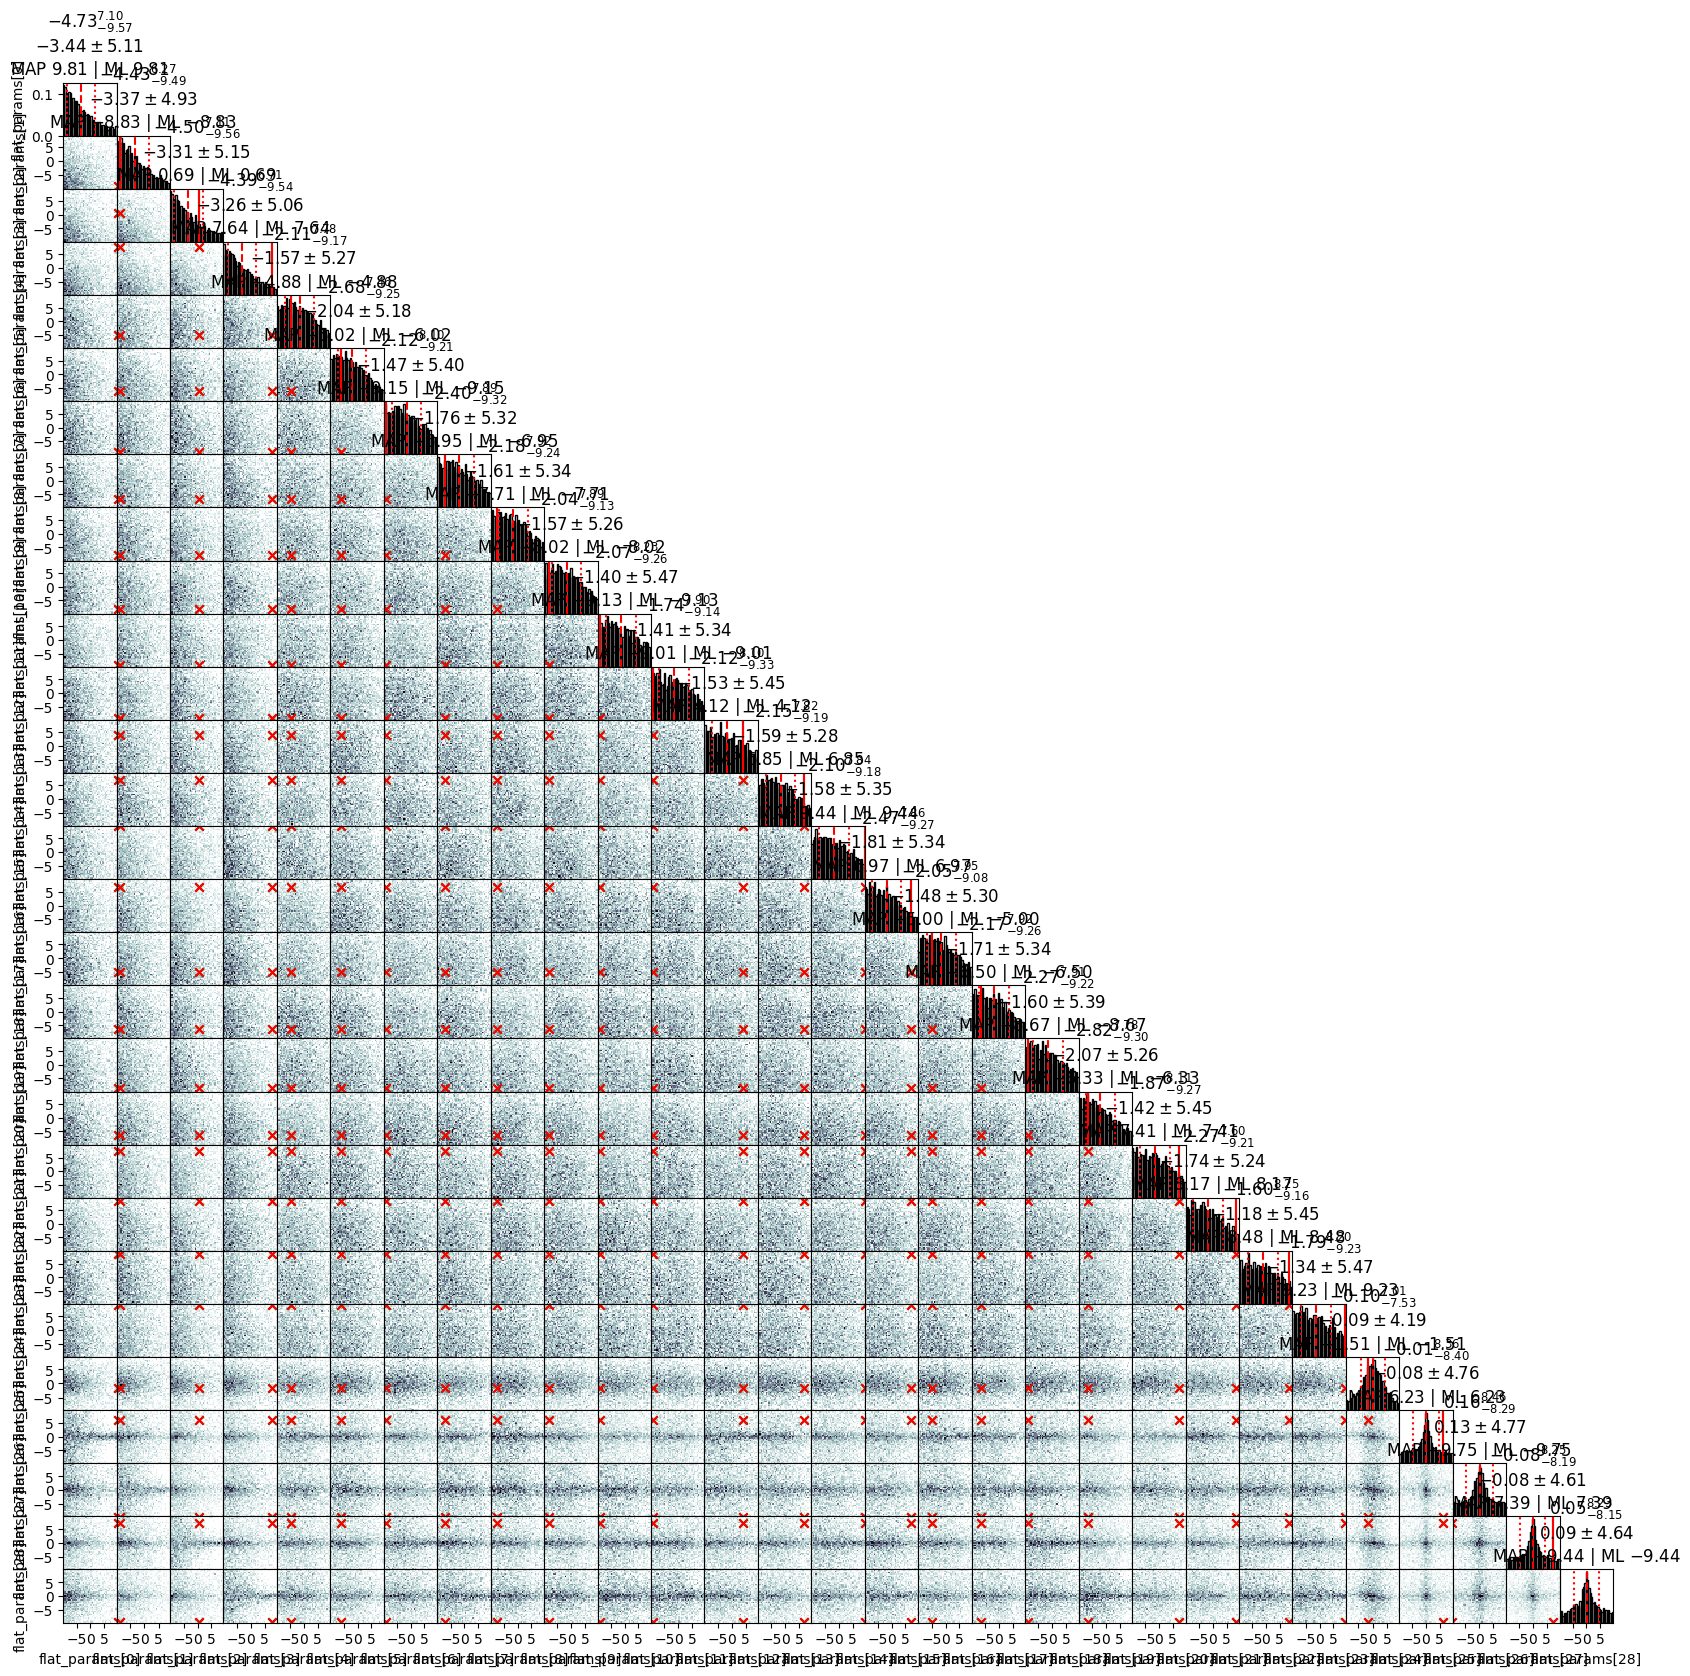

0: [0. 0. 0. 0. 0.] -> 0.0 | pred: 0.0005937305395491421 ✓
1: [0. 0. 0. 0. 1.] -> 1.0 | pred: 0.9999994039535522 ✓
2: [0. 0. 0. 1. 0.] -> 1.0 | pred: 0.9999998807907104 ✓
3: [0. 0. 0. 1. 1.] -> 0.0 | pred: 6.42026598551837e-10 ✓
4: [0. 0. 1. 0. 0.] -> 1.0 | pred: 1.0 ✓
5: [0. 0. 1. 0. 1.] -> 0.0 | pred: 6.972756239065347e-08 ✓
6: [0. 0. 1. 1. 0.] -> 0.0 | pred: 1.7175752873299643e-06 ✓
7: [0. 0. 1. 1. 1.] -> 1.0 | pred: 0.9997764229774475 ✓
8: [0. 1. 0. 0. 0.] -> 1.0 | pred: 0.9999908208847046 ✓
9: [0. 1. 0. 0. 1.] -> 0.0 | pred: 1.0467486077914145e-07 ✓
10: [0. 1. 0. 1. 0.] -> 0.0 | pred: 0.18118071556091309 ✓
11: [0. 1. 0. 1. 1.] -> 1.0 | pred: 0.999995231628418 ✓
12: [0. 1. 1. 0. 0.] -> 0.0 | pred: 0.00027995381969958544 ✓
13: [0. 1. 1. 0. 1.] -> 1.0 | pred: 0.9999985694885254 ✓
14: [0. 1. 1. 1. 0.] -> 1.0 | pred: 0.9977697134017944 ✓
15: [0. 1. 1. 1. 1.] -> 0.0 | pred: 3.0262933825575544e-10 ✓
16: [1. 0. 0. 0. 0.] -> 1.0 | pred: 1.0 ✓
17: [1. 0. 0. 0. 1.] -> 0.0 | pred: 1.297447127

In [5]:
run(num_variables - 1)
